## Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## ` Figure8_delta_dce` which is a copy and edit of, `11_delta_dce_categories` 

created by Cassie Lumbrazo\
last updated: June 2025\
run location: UAS remote linux\
python environment: **cer_treatment**

In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import scipy

In [2]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
# figure_path = 'C:\\Users\\Lumbr\\OneDrive - University of Alaska\\UW_OneDrive\\EasternCascades\\Writing\\5_Manuscript\\2_PostDefense\\python_figures\\' # Cassie new figure path
figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

# ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') # Cassie local path
ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine

Ordering:

## DeltaDCE Catgeories, 
1. Category 1: Forest Growth (forest to denser forest) --> non-treatment area  
2. Catgeory 2: Forest Thinning (forest to forest edge) --> treatment area 
3. Catgeory 3: No Change --> non-treatment area
4. Catgeory 4: Forest Growth (open to less open) --> non-treatment area 
5. Catgeory 5: Forest Thinning (open to more open) --> treatment area 
6. Catgeory 6: Forest Thinning (forest to open) --> treatment area 


In [18]:
color_cat1='olivedrab' # forest growth (forest to denser forest)
color_cat2='cornflowerblue' # forest thinning (forest to forest edge)
color_cat3='black' # no change (delta DCE close to zero)
color_cat4='mediumseagreen' # forest growth (open to less open)
color_cat5='saddlebrown' # forest thinning (open to more open)
color_cat6='darkslateblue' # forest thinning (forest to open)

In [4]:
# Calculate delta DCE
delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# Create a new variable to store the categories
# Category 1: Forest Growth: forest to denser forest (ncalm negative, rapid negative, delta DCE negative)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 1, 0)

# Category 2: Forest Thinning: forest to forest edge (ncalm negative, rapid negative, delta DCE positive) 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 2, ds['delta_dce_cat'])

# Category 3: No Change (delta DCE close to zero (absolute value less than 0.5))
ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

# Category 4: Forest Growth: open to less open (ncalm positive, rapid less than ncalm) 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] < ds['dce_ncalm']), 4, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce < 0), 4, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 5: Forest Thinning: open to more open (ncalm positive, rapid greater than ncalm)
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] > ds['dce_ncalm']), 5, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce > 0), 5, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 6: Forest Thinning: forest to open (ncalm negative, rapid positive)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] > 0), 6, ds['delta_dce_cat'])

Now, we have our delta_dce categories but we also need to do the following, (paragraph from manuscript)

"The snow depth values for both years for the delta DCE category 3 (no change) were used to compute mean values of 0.37 and 0.40 m for 2021 and 2023, respectively, and standard deviations of 0.32 and 0.22. These values were used to normalize snow depth for all pixels in each year as the number of standard deviations away from the mean value."

In [5]:
# Calculate mean and standard deviation of snow depth for delta DCE category 3 (no change)
mean_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).mean()
std_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).std()

mean_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).mean()
std_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).std()

# Normalize snow depth for each year
ds['hs_ncalm_normalized'] = (ds['hs_ncalm'] - mean_2021) / std_2021
ds['hs_rapid_normalized'] = (ds['hs_rapid'] - mean_2023) / std_2023

# Calculate the difference in normalized snow depth 
ds['hs_diff_normalized'] = ds['hs_rapid_normalized'] - ds['hs_ncalm_normalized']

# Print the means and stds 
print('ΔDCE Category 3 Mean 2021:', mean_2021.values.round(3))
print('ΔDCE Category 3 Mean 2023:', mean_2023.values.round(3))
print('ΔDCE Category 3 Std 2021:', std_2021.values.round(3))
print('ΔDCE Category 3 Std 2023:', std_2023.values.round(3))

ΔDCE Category 3 Mean 2021: 0.167
ΔDCE Category 3 Mean 2023: 0.198
ΔDCE Category 3 Std 2021: 0.225
ΔDCE Category 3 Std 2023: 0.235


Now, do the same for the difference in normalized snow depth between the two years, but also do it by aspect 

In [6]:
# difference in normalized snow depth by delta DCE category
ds['hs_diff_normalized_delta_dce_cat_1'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 1)
ds['hs_diff_normalized_delta_dce_cat_2'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 2)
ds['hs_diff_normalized_delta_dce_cat_3'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 3)
ds['hs_diff_normalized_delta_dce_cat_4'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 4)
ds['hs_diff_normalized_delta_dce_cat_5'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 5)
ds['hs_diff_normalized_delta_dce_cat_6'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 6)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_normalized_delta_dce_cat_1_s'] = ds['hs_diff_normalized_delta_dce_cat_1'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_2_s'] = ds['hs_diff_normalized_delta_dce_cat_2'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_3_s'] = ds['hs_diff_normalized_delta_dce_cat_3'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_4_s'] = ds['hs_diff_normalized_delta_dce_cat_4'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_5_s'] = ds['hs_diff_normalized_delta_dce_cat_5'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_6_s'] = ds['hs_diff_normalized_delta_dce_cat_6'].where(ds['baf_ridge'] ==  1)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_normalized_delta_dce_cat_1_n'] = ds['hs_diff_normalized_delta_dce_cat_1'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_2_n'] = ds['hs_diff_normalized_delta_dce_cat_2'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_3_n'] = ds['hs_diff_normalized_delta_dce_cat_3'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_4_n'] = ds['hs_diff_normalized_delta_dce_cat_4'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_5_n'] = ds['hs_diff_normalized_delta_dce_cat_5'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_6_n'] = ds['hs_diff_normalized_delta_dce_cat_6'].where(ds['baf_ridge'] == -1)

## Figure 6 DeltaDCE

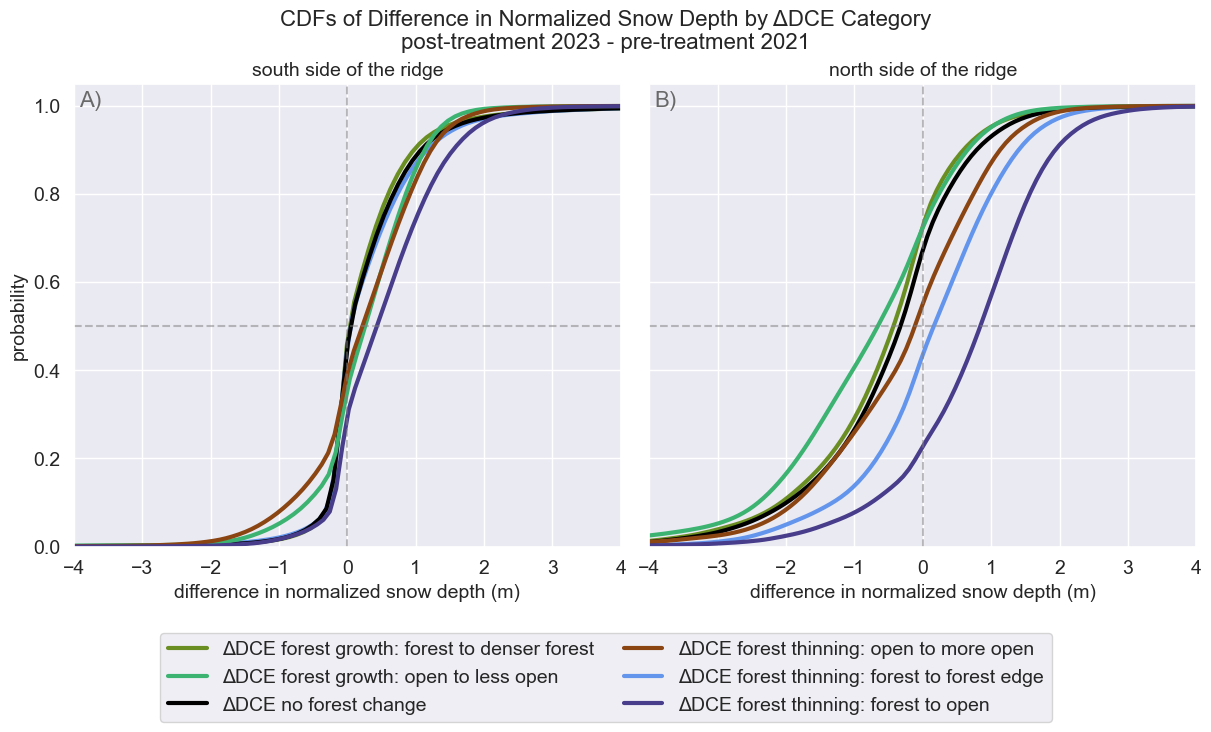

In [8]:
# plot of a histogram of all those variables 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6), constrained_layout = True)
alpha=0.7

# plots
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_1_s'].values.flatten(), ax=axes[0], color='olivedrab', label='ΔDCE forest growth: forest to denser forest', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_2_s'].values.flatten(), ax=axes[0], color='cornflowerblue',    label='ΔDCE forest thinning: forest to forest edge', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_3_s'].values.flatten(), ax=axes[0], color='black',      label='ΔDCE no forest change', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_4_s'].values.flatten(), ax=axes[0], color='mediumseagreen',      label='ΔDCE forest growth: open to less open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_5_s'].values.flatten(), ax=axes[0], color='saddlebrown',       label='ΔDCE forest thinning: open to more open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_6_s'].values.flatten(), ax=axes[0], color='darkslateblue',    label='ΔDCE forest thinning: forest to open', cumulative=True, linewidth=3)

sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_1_n'].values.flatten(), ax=axes[1], color='olivedrab', label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_2_n'].values.flatten(), ax=axes[1], color='cornflowerblue',    label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_3_n'].values.flatten(), ax=axes[1], color='black',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_4_n'].values.flatten(), ax=axes[1], color='mediumseagreen',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_5_n'].values.flatten(), ax=axes[1], color='saddlebrown',       label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_6_n'].values.flatten(), ax=axes[1], color='darkslateblue',    label=None, cumulative=True, linewidth=3)

# labels
fontsize_num = 14
axes[0].set_title('south side of the ridge', fontsize=fontsize_num)
axes[1].set_title('north side of the ridge', fontsize=fontsize_num)

axes[0].set_xlabel('difference in normalized snow depth (m)', fontsize=fontsize_num)
axes[1].set_xlabel('difference in normalized snow depth (m)', fontsize=fontsize_num)

axes[0].set_ylabel('probability', fontsize=fontsize_num)
axes[1].set_ylabel('')

axes[0].set_xlim(-4,4)

plt.suptitle('CDFs of Difference in Normalized Snow Depth by ΔDCE Category\npost-treatment 2023 - pre-treatment 2021', fontsize=16)
# axes[0].legend(loc='upper left')
# axes[1].legend(loc='upper left')
# Get the handles and labels from axes[0]
handles, labels = axes[0].get_legend_handles_labels()

# Define custom grouping for legend columns
# Left column: forest growth + no change
left_labels = [
    'ΔDCE forest growth: forest to denser forest',
    'ΔDCE forest growth: open to less open',
    'ΔDCE no forest change'
]
# Right column: forest thinning
right_labels = [
    'ΔDCE forest thinning: open to more open',
    'ΔDCE forest thinning: forest to forest edge',
    'ΔDCE forest thinning: forest to open'
]

# Match handles to labels manually
left_handles = [handles[labels.index(lbl)] for lbl in left_labels]
right_handles = [handles[labels.index(lbl)] for lbl in right_labels]

# Combine in the order you want: left column first, then right
all_handles = left_handles + right_handles
all_labels = left_labels + right_labels

fig.legend(
    all_handles,
    all_labels,
    bbox_to_anchor=(0.5, -0.12),
    loc='center',
    ncol=2,
    fontsize=fontsize_num,
    columnspacing=1.5
)


# fig.legend(bbox_to_anchor=(0.5,-0.18), loc='center', ncol=2, fontsize = fontsize_num)

# increase the size of tick marks 
axes[0].tick_params(axis='both', labelsize=fontsize_num)
axes[1].tick_params(axis='both', labelsize=fontsize_num)

# add an A), B) to the figure 
axes[0].text(0.01, 0.95, 'A)', fontsize=16, color='dimgray', transform=axes[0].transAxes)
axes[1].text(0.01, 0.95, 'B)', fontsize=16, color='dimgray', transform=axes[1].transAxes)

# add thin grey lines at 0.5 y axis and 0 x axis 
axes[0].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[1].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)
axes[1].axvline(0, color='grey', linestyle='--', alpha=0.5)

# export the figure with high resolution
figure_name = 'figure6_delta_dce.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

## Now, I want to create a map for the delta DCE Categories...

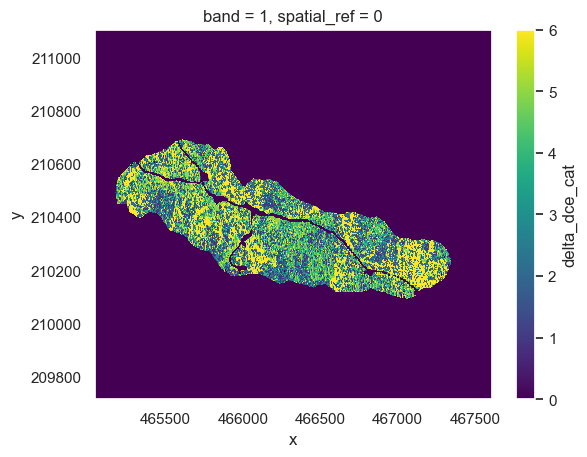

In [9]:
ds['delta_dce_cat'].plot()

In [10]:
# list the unique values in the delta_dce_cat variable
unique_values = ds['delta_dce_cat'].values.flatten()
unique_values = np.unique(unique_values)
print("Unique values in delta_dce_cat:", unique_values)

Unique values in delta_dce_cat: [0 1 2 3 4 5 6]


Now, I just need to get it formatted...

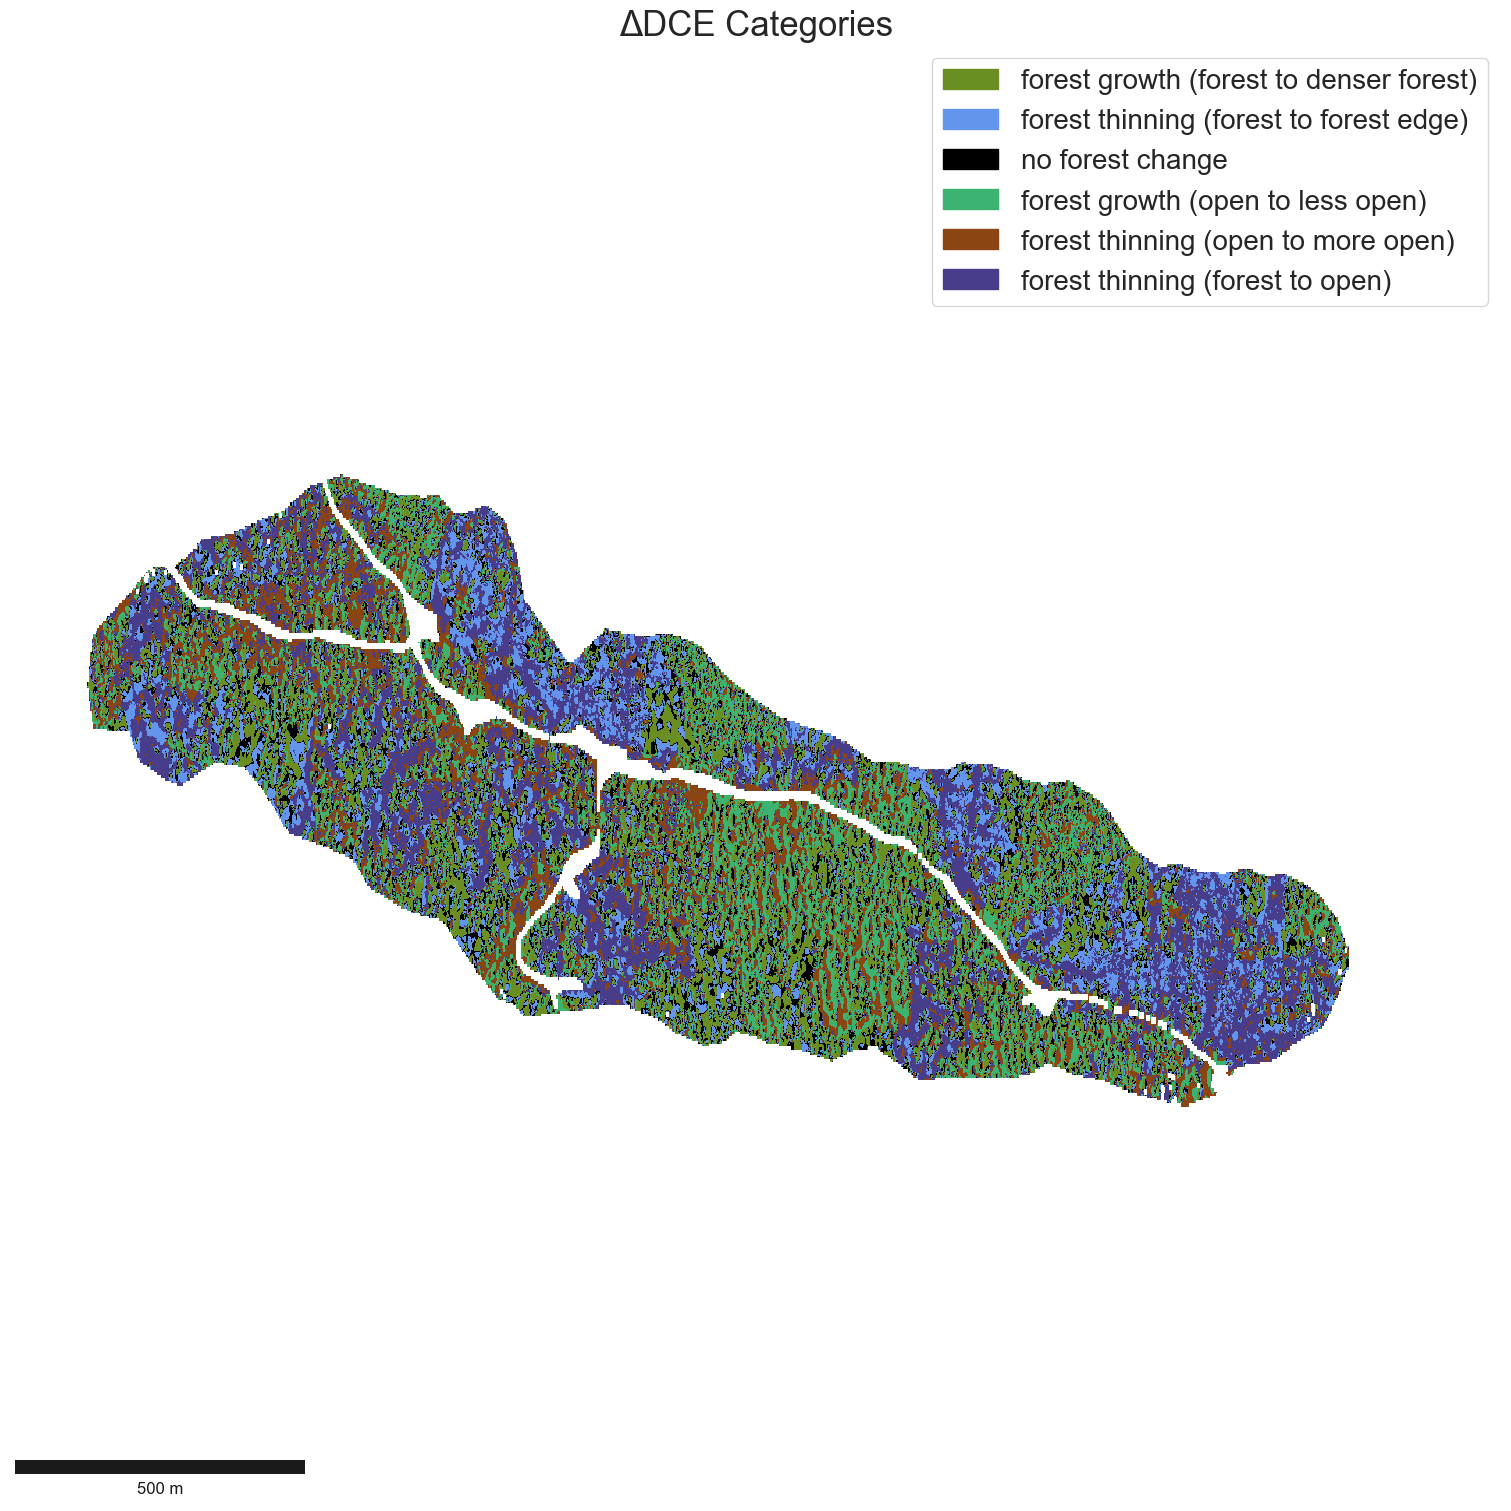

In [19]:
fig = plt.figure(figsize=(15,15), constrained_layout = True)
ax = fig.gca()

color_zero = 'white'

# plot 3
ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, color_cat1,color_cat2,color_cat3,color_cat4,color_cat5,color_cat6]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {color_cat1: "forest growth (forest to denser forest)", 
                  color_cat2: "forest thinning (forest to forest edge)",
                  color_cat3: "no forest change",                 
                  color_cat4: "forest growth (open to less open)",
                  color_cat5: "forest thinning (open to more open)",
                  color_cat6: "forest thinning (forest to open)",}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white", fontsize=20)

plt.title('')

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

plt.title('ΔDCE Categories', fontsize=25)

plt.show()

If I were to color these as control and treatment areas,

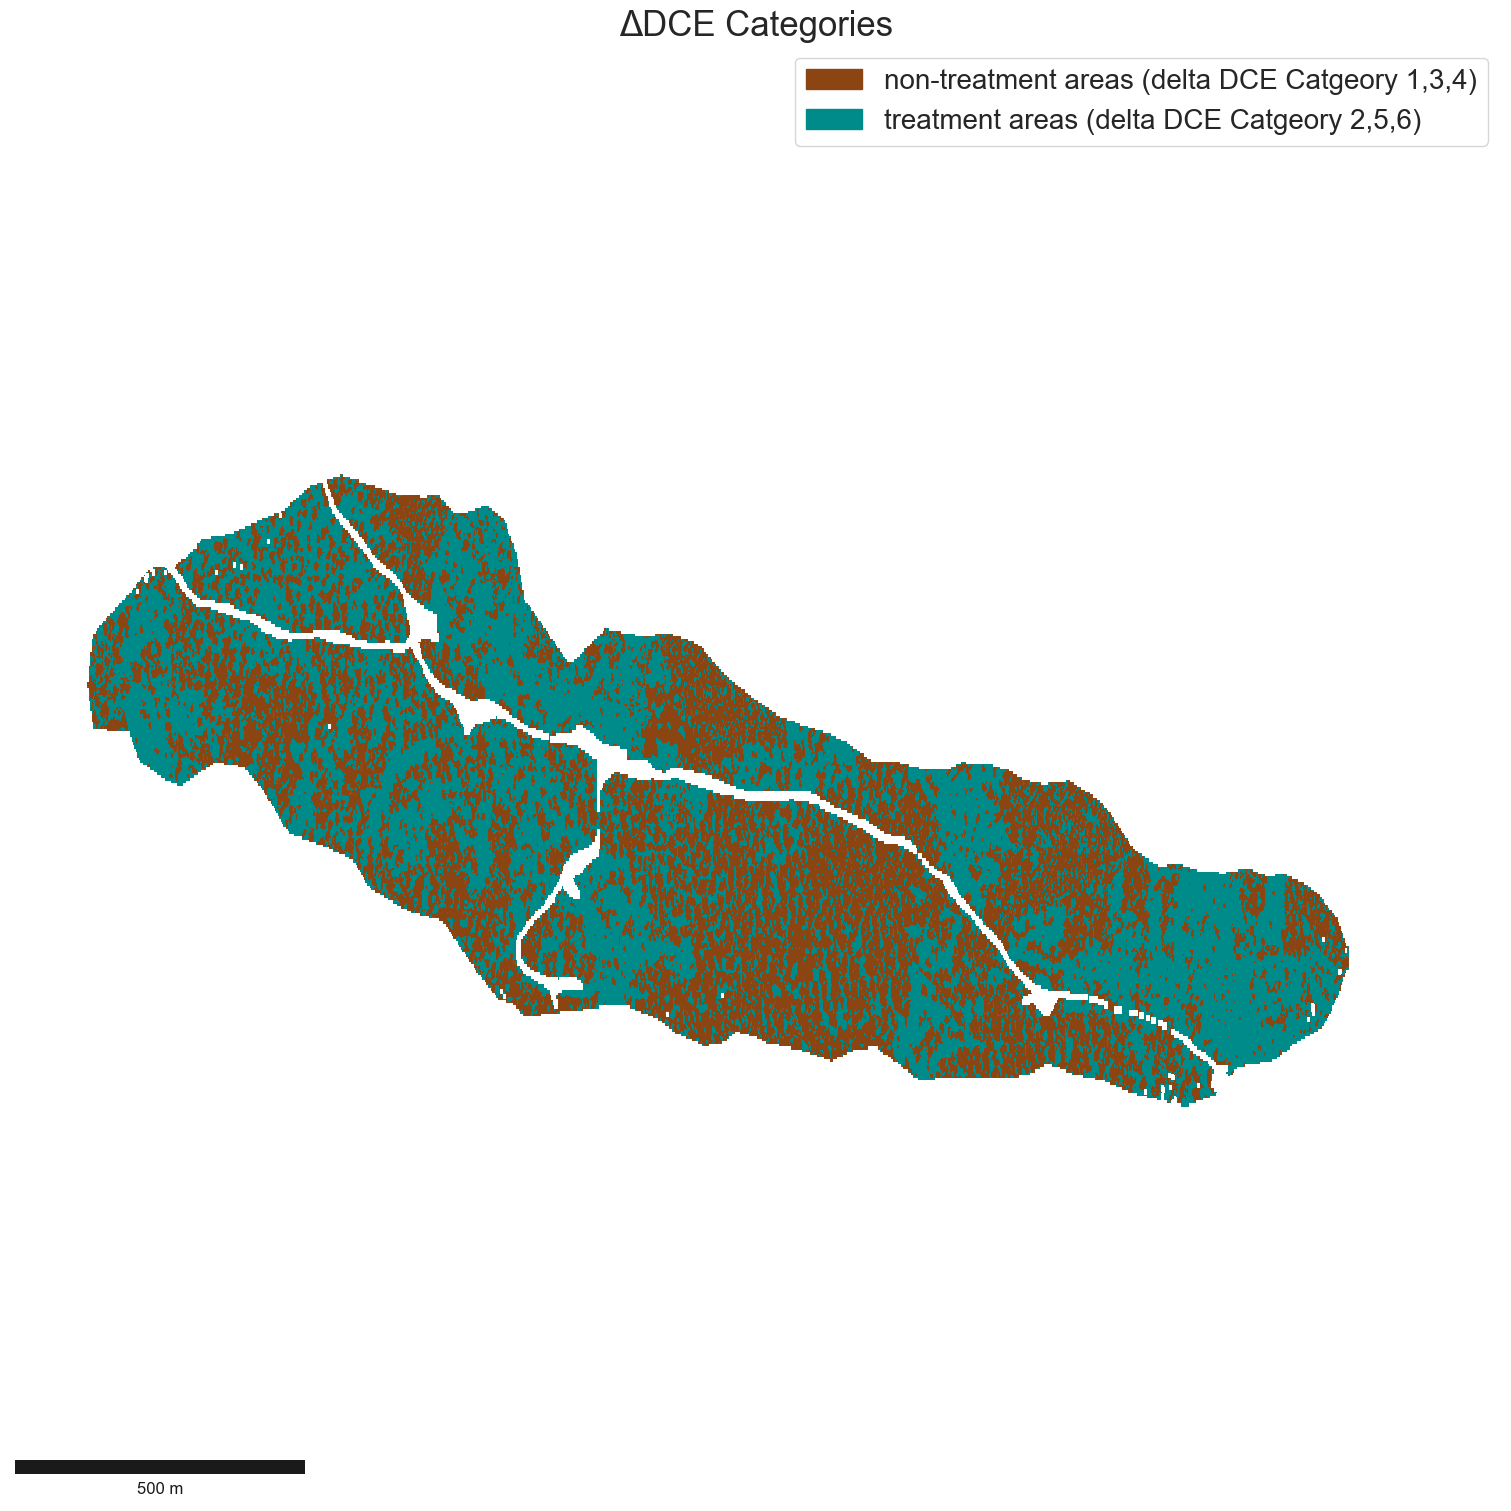

In [24]:
fig = plt.figure(figsize=(15,15), constrained_layout = True)
ax = fig.gca()

color_zero = 'white'

# colorcontrol = 'dimgray'
colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'

# plot 3
ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol: "non-treatment areas (delta DCE Catgeory 1,3,4)", 
                  colortreatment: "treatment areas (delta DCE Catgeory 2,5,6)"}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white", fontsize=20)

plt.title('')

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

plt.title('ΔDCE Categories', fontsize=25)

plt.show()

Just checking to make sure the no change category has data...

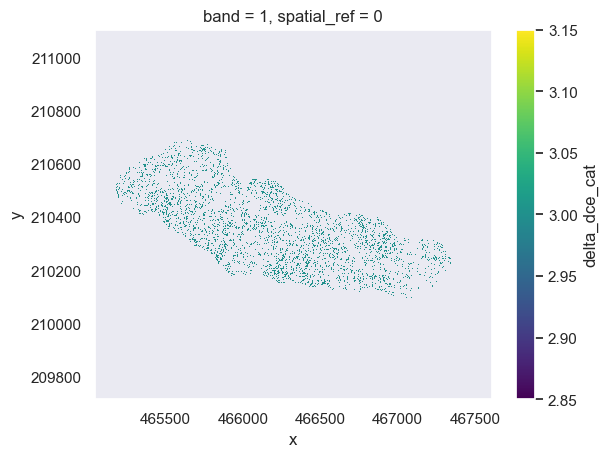

In [13]:
ds['delta_dce_cat'].where(ds['delta_dce_cat'] == 3).plot()